<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2023/blob/main/notebooks/es6/AML_2023_HandsOn_6_YOLO_part_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLO: Real-Time Object Detection
### YOLO v3
You only look once (YOLO) is a state-of-the-art, real-time object detection system. On a Pascal Titan X it processes images at 30 FPS and has a mAP of 57.9% on COCO test-dev.

<img src="https://pjreddie.com/media/image/map50blue.png" width = 50% />


You can find all the materials used for this notebook in the ufficial site
[SITE](https://pjreddie.com/darknet/yolo/)

We will also need to look at the 
[PAPER](https://pjreddie.com/media/files/papers/YOLOv3.pdf)
The third version of YOLO is based on YOLO9000 and YOLOv2, you can find the paper [HERE](https://openaccess.thecvf.com/content_cvpr_2017/papers/Redmon_YOLO9000_Better_Faster_CVPR_2017_paper.pdf)

The slides for the lesson
[SLIDE](https://docs.google.com/presentation/d/11MtM__NsLDSoS0eaARADNAcUpBTORCIyUX7X_dwkP7M/edit?usp=sharing)

In [1]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import cv2
import os
import time
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
#your drive (check if the path is the same)
%cd /content/gdrive/MyDrive/ 

/content/gdrive/MyDrive


In [4]:
# to check where u are
%pwd

'/content/gdrive/MyDrive'

In [5]:
import os
def CreateDir(path):
	# Create a directory if it does not exist
	success = os.path.exists(path)
	if not success:
		os.makedirs(path)
CreateDir("Yolo_v3")# or whatever you like 

In [6]:
#the folder you
%cd Yolo_v3 
%pwd

/content/gdrive/MyDrive/Yolo_v3


'/content/gdrive/MyDrive/Yolo_v3'

In [7]:
CreateDir("input/data-for-yolo-v3-kernel/")# to store weigths
CreateDir("working")# working folder
CreateDir('working/input')
CreateDir('working/output')

weightsfile = 'input/data-for-yolo-v3-kernel/yolov3.weights'
classfile = 'input/data-for-yolo-v3-kernel/coco.names'
cfgfile = 'working/yolov3.cfg'# here we will find the architecture details
sample_img1 = 'working/input/dog-cycle-car.png'
input_dir = 'working/input'
output_dir = 'working/output'
nms_thesh = 0.5 # suppression for boxes that are too simila to each other

In [8]:
! wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
! wget https://github.com/ayooshkathuria/pytorch-yolo-v3/raw/master/dog-cycle-car.png
! wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -P input/data-for-yolo-v3-kernel/
! mv dog-cycle-car.png working/input
! mv yolov3.cfg working/


--2023-04-18 11:12:13--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0.003s  

2023-04-18 11:12:14 (3.02 MB/s) - ‘yolov3.cfg’ saved [8342/8342]

--2023-04-18 11:12:14--  https://github.com/ayooshkathuria/pytorch-yolo-v3/raw/master/dog-cycle-car.png
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ayooshkathuria/pytorch-yolo-v3/master/dog-cycle-car.png [following]
--2023-04-18 11:12:14--  https://raw.gi

In [9]:
# this one is big so try to download it only once
success = os.path.exists(weightsfile)
if not success:
 ! wget https://pjreddie.com/media/files/yolov3.weights -P input/data-for-yolo-v3-kernel/

In [10]:
# A bunch of random images found on the web
! wget https://www.dire.it/wp-content/uploads/2020/11/donna-e-scienza-2-1024x576.jpeg -O working/input/marcella.jpg 
! wget https://www.unive.it/pag/fileadmin/user_upload/dipartimenti/DAIS/img/600x362/viatori_lab3_600x362.jpg -O working/input/computer.jpg 
! wget https://previews.123rf.com/images/fendero/fendero1505/fendero150500045/40294146-a-cat-on-the-table.jpg -O working/input/gatto.jpg 

--2023-04-18 11:12:15--  https://www.dire.it/wp-content/uploads/2020/11/donna-e-scienza-2-1024x576.jpeg
Resolving www.dire.it (www.dire.it)... 104.26.0.60, 104.26.1.60, 172.67.69.153, ...
Connecting to www.dire.it (www.dire.it)|104.26.0.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79485 (78K) [image/jpeg]
Saving to: ‘working/input/marcella.jpg’

working/input/marce 100%[===================>]  77.62K  --.-KB/s    in 0.01s   

2023-04-18 11:12:15 (5.75 MB/s) - ‘working/input/marcella.jpg’ saved [79485/79485]

--2023-04-18 11:12:15--  https://www.unive.it/pag/fileadmin/user_upload/dipartimenti/DAIS/img/600x362/viatori_lab3_600x362.jpg
Resolving www.unive.it (www.unive.it)... 157.138.7.88
Connecting to www.unive.it (www.unive.it)|157.138.7.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206981 (202K) [image/jpeg]
Saving to: ‘working/input/computer.jpg’

working/input/compu 100%[===================>] 202.13K   225KB/s    in 0.9s  

In [11]:
def parse_cfg(config_file):
    file = open(config_file,'r')# read file
    file = file.read().split('\n')# split each line (\n means new line)
    file =  [line for line in file if len(line)>0 and line[0] != '#']# take only non-empty lines and remove comments (lines that start with #)
    file = [line.lstrip().rstrip() for line in file]# removing extra spaces

    final_list = []
    element_dict = {}
    for line in file:

        if line[0] == '[':# if line starts with a [, it is a new element
            if len(element_dict) != 0:     # appending the dict stored on previous iteration
                    final_list.append(element_dict)
                    element_dict = {} # again emtying dict
            element_dict['type'] = ''.join([i for i in line if i != '[' and i != ']'])# put in the dict what is inside brackets
            
        else:
            val = line.split('=')# if not, it is a new key/value pair of the dictionary
            element_dict[val[0].rstrip()] = val[1].lstrip()  #removing spaces on left and right side
        
    final_list.append(element_dict) # appending the values stored for last set
    return final_list

In [12]:
print(parse_cfg(cfgfile)[0:3]) # this function read the config file and put the details in a python dictionary

[{'type': 'net', 'batch': '64', 'subdivisions': '16', 'width': '608', 'height': '608', 'channels': '3', 'momentum': '0.9', 'decay': '0.0005', 'angle': '0', 'saturation': '1.5', 'exposure': '1.5', 'hue': '.1', 'learning_rate': '0.001', 'burn_in': '1000', 'max_batches': '500200', 'policy': 'steps', 'steps': '400000,450000', 'scales': '.1,.1'}, {'type': 'convolutional', 'batch_normalize': '1', 'filters': '32', 'size': '3', 'stride': '1', 'pad': '1', 'activation': 'leaky'}, {'type': 'convolutional', 'batch_normalize': '1', 'filters': '64', 'size': '3', 'stride': '2', 'pad': '1', 'activation': 'leaky'}]


In [13]:
class DummyLayer(nn.Module):
    def __init__(self):
        super(DummyLayer, self).__init__()
        

        
class DetectionLayer(nn.Module):
    def __init__(self, anchors):
        super(DetectionLayer, self).__init__()
        self.anchors = anchors
        
        

def create_model(blocks):
#     blocks = parse_cfg(cfgfile)
    darknet_details = blocks[0]
    channels = 3 
    output_filters = []
    modulelist = nn.ModuleList()
    
    for i,block in enumerate(blocks[1:]):
        seq = nn.Sequential()
        if (block["type"] == "convolutional"):
            activation = block["activation"]
            filters = int(block["filters"])
            kernel_size = int(block["size"])
            strides = int(block["stride"])
            use_bias= False if ("batch_normalize" in block) else True
            pad = (kernel_size - 1) // 2
            
            conv = nn.Conv2d(in_channels=channels, out_channels=filters, kernel_size=kernel_size, 
                             stride=strides, padding=pad, bias = use_bias)
            seq.add_module("conv_{0}".format(i), conv)
            
            if "batch_normalize" in block:
                bn = nn.BatchNorm2d(filters)
                seq.add_module("batch_norm_{0}".format(i), bn)

            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace = True)
                seq.add_module("leaky_{0}".format(i), activn)
            
        elif (block["type"] == "upsample"):
            upsample = nn.Upsample(scale_factor = 2, mode = "bilinear")
            seq.add_module("upsample_{}".format(i), upsample)
        
        elif (block["type"] == 'route'):
            # start and end is given in format (eg:-1 36 so we will find layer number from it.
            # we will find layer number in negative format
            # so that we can get the number of filters in that layer
            block['layers'] = block['layers'].split(',')
            block['layers'][0] = int(block['layers'][0])
            start = block['layers'][0]
            if len(block['layers']) == 1:               
                filters = output_filters[i + start]
                       
            
            elif len(block['layers']) > 1:
                block['layers'][1] = int(block['layers'][1]) - i 
                end = block['layers'][1]
                filters = output_filters[i + start] + output_filters[i + end]
                  
            
            route = DummyLayer()
            seq.add_module("route_{0}".format(i),route)
                
      
        elif block["type"] == "shortcut":
            from_ = int(block["from"])
            shortcut = DummyLayer()
            seq.add_module("shortcut_{0}".format(i),shortcut)
            
            
        elif block["type"] == "yolo":
            mask = block["mask"].split(",")
            mask = [int(m) for m in mask]
            anchors = block["anchors"].split(",")
            anchors = [(int(anchors[i]), int(anchors[i + 1])) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in mask]
            block["anchors"] = anchors
            
            detectorLayer = DetectionLayer(anchors)
            seq.add_module("Detection_{0}".format(i),detectorLayer)
                
        modulelist.append(seq)
        output_filters.append(filters)  
        channels = filters
    
    return darknet_details, modulelist

In [14]:
def Prediction(x,inp_dim,anchors,num_classes,CUDA=False):
    # x --> 4D feature map
    batch_size = x.size(0)
    grid_size = x.size(2)
    stride =  inp_dim // x.size(2)   # factor by which current feature map reduced from input
#     grid_size = inp_dim // stride
    
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)
# 
    prediction = x.view(batch_size, bbox_attrs*num_anchors, grid_size*grid_size)
    prediction = prediction.transpose(1,2).contiguous()
    prediction = prediction.view(batch_size, grid_size*grid_size*num_anchors, bbox_attrs)
    
    # the dimension of anchors is wrt original image.We will make it corresponding to feature map
    anchors = [(a[0]/stride, a[1]/stride) for a in anchors]
    #Sigmoid the  centre_X, centre_Y. and object confidencce
    prediction[:,:,0] = torch.sigmoid(prediction[:,:,0])
    prediction[:,:,1] = torch.sigmoid(prediction[:,:,1])
    prediction[:,:,4] = torch.sigmoid(prediction[:,:,4])
    #Add the center offsets
    grid = np.arange(grid_size)
    a,b = np.meshgrid(grid, grid)

    x_offset = torch.FloatTensor(a).view(-1,1) #(1,gridsize*gridsize,1)
    y_offset = torch.FloatTensor(b).view(-1,1)

    if CUDA:
        x_offset = x_offset.cuda()
        y_offset = y_offset.cuda()

    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1,num_anchors).view(-1,2).unsqueeze(0)
    

    prediction[:,:,:2] += x_y_offset

    #log space transform height and the width
    anchors = torch.FloatTensor(anchors)

    if CUDA:
        anchors = anchors.cuda()

    anchors = anchors.repeat(grid_size*grid_size, 1).unsqueeze(0)
    prediction[:,:,2:4] = torch.exp(prediction[:,:,2:4])*anchors #width and height
    prediction[:,:,5: 5 + num_classes] = torch.sigmoid((prediction[:,:, 5 : 5 + num_classes]))    
    prediction[:,:,:4] *= stride    
    return prediction

In [15]:
class Darknet(nn.Module):
    def __init__(self, cfgfile):
        super(Darknet, self).__init__()
        self.blocks = parse_cfg(cfgfile)
        self.net_info, self.module_list = create_model(self.blocks)
        
    def forward(self, x, CUDA=False):
        modules = self.blocks[1:]
        outputs = {}   #We cache the outputs for the route layer
        write = 0     #This is explained a bit later
        for i, module in enumerate(modules):        
            module_type = (module["type"])
            if module_type == "convolutional" or module_type == "upsample":
                x = self.module_list[i](x)
                outputs[i] = x
                
            elif module_type == "route":
                layers = module["layers"]
                layers = [int(a) for a in layers]
                if len(layers) == 1:
                    x = outputs[i + layers[0]]
                if len(layers) > 1:
                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]
                    x = torch.cat((map1,map2),1)
       
                outputs[i] = x
                
            elif  module_type == "shortcut":
                from_ = int(module["from"])

                # just adding outputs for residual network
                x = outputs[i-1] + outputs[i+from_]  
                outputs[i] = x
                
            elif module_type == 'yolo':
                anchors = self.module_list[i][0].anchors
                
                #Get the input dimensions
                inp_dim = int(self.net_info["height"])
                #Get the number of classes
                num_classes = int(module["classes"])
            
                #Transform 
                x = x.data   # get the data at that point
                x = Prediction(x,inp_dim,anchors,num_classes)
                
                if not write:              #if no collector has been intialised. 
                    detections = x
                    write = 1
                else:       
                    detections = torch.cat((detections, x), 1)

                outputs[i] = outputs[i-1]
                
        try:
            return detections   #return detections if present
        except:
            return 0
     
    def load_weights(self, weightfile):
        
        #Open the weights file
        fp = open(weightfile, "rb")

        #The first 4 values are header information 
        # 1. Major version number
        # 2. Minor Version Number
        # 3. Subversion number 
        # 4. IMages seen 
        header = np.fromfile(fp, dtype = np.int32, count = 5)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]
        
        #The rest of the values are the weights
        # Let's load them up
        weights = np.fromfile(fp, dtype = np.float32)
        
        ptr = 0
        for i in range(len(self.module_list)):
            module_type = self.blocks[i + 1]["type"]
            
            if module_type == "convolutional":
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i+1]["batch_normalize"])
                except:
                    batch_normalize = 0
                
                conv = model[0]
                
                if (batch_normalize):
                    bn = model[1]
                    
                    #Get the number of weights of Batch Norm Layer
                    num_bn_biases = bn.bias.numel()
                    
                    #Load the weights
                    bn_biases = torch.from_numpy(weights[ptr:ptr + num_bn_biases])
                    ptr += num_bn_biases
                    
                    bn_weights = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
                    
                    bn_running_mean = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
                    
                    bn_running_var = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
                    
                    #Cast the loaded weights into dims of model weights. 
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)

                    #Copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.copy_(bn_running_mean)
                    bn.running_var.copy_(bn_running_var)
                
                else:
                    #Number of biases
                    num_biases = conv.bias.numel()
                
                    #Load the weights
                    conv_biases = torch.from_numpy(weights[ptr: ptr + num_biases])
                    ptr = ptr + num_biases
                    
                    #reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)
                    
                    #Finally copy the data
                    conv.bias.data.copy_(conv_biases)
                    
                    
                #Let us load the weights for the Convolutional layers
                num_weights = conv.weight.numel()
                
                #Do the same as above for weights
                conv_weights = torch.from_numpy(weights[ptr:ptr+num_weights])
                ptr = ptr + num_weights

                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)
                # Note: we dont have bias for conv when batch normalization is there

# Prediction

In [16]:
def bbox_iou(box1, box2):
    """
    Returns the IoU of two bounding boxes 
    
    """
    #Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]
    
    #get the corrdinates of the intersection rectangle
    inter_rect_x1 =  torch.max(b1_x1, b2_x1)
    inter_rect_y1 =  torch.max(b1_y1, b2_y1)
    inter_rect_x2 =  torch.min(b1_x2, b2_x2)
    inter_rect_y2 =  torch.min(b1_y2, b2_y2)
    
    #Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
 
    #Union Area
    b1_area = (b1_x2 - b1_x1 + 1)*(b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1)*(b2_y2 - b2_y1 + 1)
    
    iou = inter_area / (b1_area + b2_area - inter_area)
    
    return iou


def unique(tensor):
    tensor_np = tensor.cpu().numpy()
    unique_np = np.unique(tensor_np)
    unique_tensor = torch.from_numpy(unique_np)
    
    tensor_res = tensor.new(unique_tensor.shape)
    tensor_res.copy_(unique_tensor)
    return tensor_res



# Detection

In [17]:
# Detection

In [18]:
# Utility functions to read the class names

# function to load the classes
def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names


In [19]:
CUDA = False
batch_size = 2
#Set up the neural network
print("Loading network.....")
model = Darknet(cfgfile)# read the file and make the network
model.load_weights(weightsfile)# load the pretrained net
print("Network successfully loaded")
classes = load_classes(classfile)# from output to classes names
print('Classes loaded')
inp_dim = int(model.net_info["height"])
print("in dim : ",inp_dim)
assert inp_dim % 32 == 0 
assert inp_dim > 32

Loading network.....
Network successfully loaded
Classes loaded
in dim :  608


In [20]:
print(classes)# ordered classes that
print("this dataset has N classes : ", len(classes))# YOLO9000 can recognize 9000 object, this is a benchmark dataset

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
this dataset has N classes :  80


In [21]:
# not needed in inference
#If there's a GPU availible, put the model on GPU
if CUDA:
    model.cuda()

#Set the model in evaluation mode
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch

In [22]:
os.listdir(input_dir)# our images

['dog-cycle-car.png', 'marcella.jpg', 'computer.jpg', 'gatto.jpg']

# Preprocessing images

In [23]:
# function converting images from opencv format to torch format
def prep_image(img, inp_dim):
    """
    Prepare image for inputting to the neural network. 
    
    Returns a Variable 
    """

    orig_im = cv2.imread(img)# read it as BGR
    dim = orig_im.shape[1], orig_im.shape[0]
    img = (letterbox_image(orig_im, (inp_dim, inp_dim)))
    img_ = img[:,:,::-1].transpose((2,0,1)).copy() # transform it to RGB and put it as channel first for pytorch
    img_ = torch.from_numpy(img_).float().div(255.0) # to tensor,
    return img_, orig_im, dim

#function letterbox_image that resizes our image, keeping the 
# aspect ratio consistent, and padding the left out areas with the color (128,128,128)
def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding'''
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 128)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,:] = resized_image
    
    return canvas

In [24]:
def step_prep(DEBUG=False):
  if DEBUG:
    # step by step explanation of the preprocessing
    orig_im = cv2.imread("working/input/gatto.jpg")#  PLT and open CV read channels in a different order
    #if you put ,cv2.COLOR_BGR2RGB as argument, the cat would appear blue (try it).
    plt.figure()
    plt.imshow(orig_im)
    plt.title("original image, any size")
    dim = orig_im.shape[1], orig_im.shape[0]
    img = (letterbox_image(orig_im, (inp_dim, inp_dim)))
    plt.figure()
    plt.imshow(img)
    plt.title("squared and padded")
    img_ = img[:,:,::-1].copy()
    plt.figure()
    plt.imshow(img_)
    plt.title("as RGB")
    img_ = torch.from_numpy(img_.transpose((2,0,1))).float().div(255.0).unsqueeze(0) 
    print("input tensor with batch deim and channel first : ", img_.shape)
    return 0

_ = step_prep(DEBUG=False) 

In [152]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.utils.data as data

imlist = [os.path.join(os.path.realpath('.'), input_dir, img) for img in os.listdir(input_dir)]

class ImageGenerator(Dataset):
  

    def __init__(self, imlist,inp_dim,GET_ORIG=False ):
        self.imlist =imlist
        self.inp_dim =inp_dim 
        self.orig=GET_ORIG
        
    def __len__(self):
        return len(self.imlist)

    def __getitem__(self, idx):

        im_file = self.imlist[idx]
        
        img_, orig_im, dim =  prep_image(im_file,inp_dim)

        dim = torch.FloatTensor(dim).repeat(2)
        if self.orig:
          return img_, dim,orig_im
        else:
          return img_, dim

In [26]:
test_images = ImageGenerator(imlist,inp_dim,GET_ORIG=False)

In [27]:
test_loader = DataLoader(test_images, batch_size=batch_size, shuffle=False)# 

In [28]:
for i in test_loader:
  print(len(i))
  print(i[0].shape)
  print(i[1].shape)
 
  break

2
torch.Size([2, 3, 608, 608])
torch.Size([2, 4])


In [146]:

    
outs = [] 
im_dim_list = []   
i = 0
write = False
    
objs = {}    
for batch, dim in test_loader:
        #load the image 
        start = time.time()
        if CUDA:
            batch = batch.cuda()       
        #Apply offsets to the result predictions
        #Tranform the predictions as described in the YOLO paper
        #flatten the prediction vector 
        # B x (bbox cord x no. of anchors) x grid_w x grid_h --> B x bbox x (all the boxes) 
        # Put every proposed box as a row.
        with torch.no_grad():
            out = model(Variable(batch), CUDA).detach().cpu()
        if outs == []:
          outs = out
          im_dim_list = dim
        else:
          outs = torch.cat((outs,out))
          im_dim_list  = torch.cat((im_dim_list,dim))
out=[]# free 

print("all image processed!",outs.shape)

all image processed! torch.Size([4, 22743, 85])


In [30]:
(19**2+38**2+76**2)*3 # number of prediction

22743

In [122]:
example = outs[1,0:(3*(19**2)),4].numpy()# most probaple centers, first block
person_prob = outs[1,0:(3*(19**2)),5].numpy() # cattines, first block

In [123]:
print(example.shape[0]/19/3)
bb1=example[0:-2:3].reshape(19,19)
cc1_person = person_prob[0:-2:3].reshape(19,19)
bb2=example[1:-1:3].reshape(19,19)
cc2_person = person_prob[1:-1:3].reshape(19,19)
bb3=example[2::3].reshape(19,19)

19.0


In [124]:
imlist[3]

'/content/gdrive/MyDrive/Yolo_v3/working/input/gatto.jpg'

prob person 0.99995947


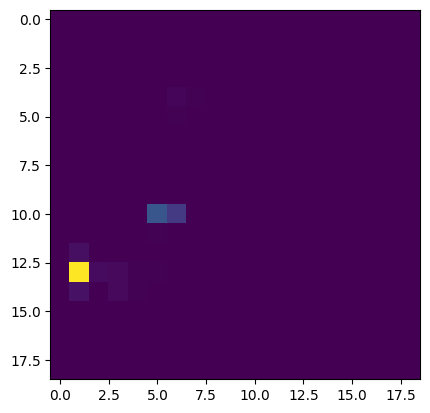

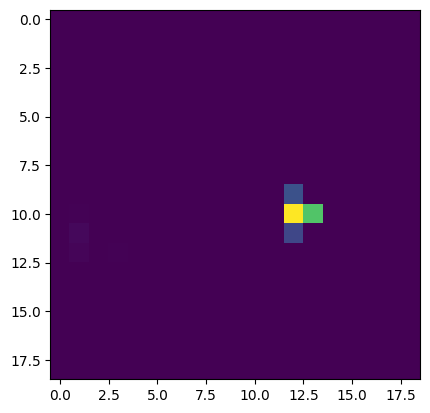

In [127]:
plt.figure()
plt.imshow(bb1)
plt.figure()
plt.imshow(bb2)

center = bb2.flatten().argmax()
print("prob person" , cc2_person.flatten()[center])

In [136]:
def write_results(prediction, confidence, num_classes, nms_conf = 0.4):
    # taking only values above a particular threshold and set rest everything to zero
    conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)# only best centers are considered, a big p0 means a plausible center
    prediction = prediction*conf_mask
    
    
    #(center x, center y, height, width) attributes of our boxes, 
    #to (top-left corner x, top-left corner y, right-bottom corner x, right-bottom corner y)
    box_corner = prediction.new(prediction.shape)
    box_corner[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_corner[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_corner[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
    box_corner[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_corner[:,:,:4]
    
    
    write = False
    
    # we can do non max suppression only on individual images so we will loop through images
    for ind in range(prediction.shape[0]):  
        image_pred = prediction[ind] 
        # we will take only those rows with maximm class probability
        # and corresponding index
        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)# part of the tensor that stores probs
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        # concatinating index values and max probability with box cordinates as columns
        image_pred = torch.cat(seq, 1) 
        #Remember we had set the bounding box rows having a object confidence
        # less than the threshold to zero? Let's get rid of them.
        non_zero_ind =  (torch.nonzero(image_pred[:,4])) # non_zero_ind will give the indexes 
        image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
        try:
            #Get the various classes detected in the image
            img_classes = unique(image_pred_[:,-1]) # -1 index holds the class index
        except:
             continue
       
        for cls in img_classes:
            #perform NMS
            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            image_pred_class = image_pred_[class_mask_ind].view(-1,7)
            
            # sort them based on probability
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]#getting index
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)
            
            for i in range(idx):
                #Get the IOUs of all boxes that come after the one we are looking at 
                 #in the loop
                try:
                    ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                except ValueError:
                    break
                except IndexError:
                    break
                
                #Zero out all the detections that have IoU > treshhold
                iou_mask = (ious < nms_conf).float().unsqueeze(1)
                image_pred_class[i+1:] *= iou_mask
                
                #Remove the non-zero entries
                non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                image_pred_class = image_pred_class[non_zero_ind].view(-1,7)
          
            #Concatenate the batch_id of the image to the detection
            #this helps us identify which image does the detection correspond to 
            #We use a linear straucture to hold ALL the detections from the batch
            #the batch_dim is flattened
            #batch is identified by extra batch column
            
            #creating a row with index of images
            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)
            seq = batch_ind, image_pred_class
            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))
    
    return output

In [137]:
prediction = write_results(outs, 0.5, 80, nms_conf = nms_thesh)

In [145]:
print(prediction[:,0])#index of all the images that got a prediction
print(prediction[-1,:])#a particular bounding box (first elemt is the index of the image)

tensor([0., 0., 0., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3.])
tensor([  3.0000, 312.9191, 199.5846, 553.9547, 369.8362,   0.9973,   0.9991,
         15.0000])


In [147]:
im_dim_list# processed images original dims

tensor([[ 602.,  452.,  602.,  452.],
        [1024.,  576., 1024.,  576.],
        [ 600.,  362.,  600.,  362.],
        [1300.,  866., 1300.,  866.]])

In [148]:
#Before we draw the bounding boxes, the predictions contained in our output tensor 
#are predictions on the padded image, and not the original image. Merely, re-scaling them 
#to the dimensions of the input image won't work here. We first need to transform the
#co-ordinates of the boxes to be measured with respect to boundaries of the area on the
#padded image that contains the original image

# 0 - idx image
# 1,3 x dims
# 2,4 y dims

im_dim_list = torch.index_select(im_dim_list, 0, prediction[:,0].long())
scaling_factor = torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)
prediction[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
prediction[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2
prediction[:,1:5] /= scaling_factor
    
for i in range(prediction.shape[0]):
    prediction[i, [1,3]] = torch.clamp(prediction[i, [1,3]], 0.0, im_dim_list[i,0])# if box is bigger than image then the bord is selected
    prediction[i, [2,4]] = torch.clamp(prediction[i, [2,4]], 0.0, im_dim_list[i,1])
        
            

In [164]:
prediction.shape# same predictions but in the original image ratio
prediction = prediction.numpy()

In [157]:
test_images = ImageGenerator(imlist,inp_dim,GET_ORIG=True)
len(test_images)

4

In [167]:
         


def write(x, img):
    c1 = tuple(x[1:3].astype("int"))
    c2 = tuple(x[3:5].astype("int"))
    #print(c1)
    
    cls = int(x[-1])# CLASS for the BOX
    label = "{0}".format(classes[cls])# to name class
    color = (0,0,255)# BGR so RED!
    cv2.rectangle(img, c1, c2,color, 2) # define a rectangle in open CV
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1) #write the label over the box
    return img
    
            
    

In [168]:
det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format(output_dir,x.split("/")[-1]))# array with outputs

In [169]:
det_names

0    working/output/det_dog-cycle-car.png
1         working/output/det_marcella.jpg
2         working/output/det_computer.jpg
3            working/output/det_gatto.jpg
dtype: object

In [170]:
for i, [_, _,orig_im] in enumerate(test_images):
  
  img = orig_im
  pred_for_i = prediction[prediction[:,0]==i,:]
  for x in pred_for_i :
    img = write(x,img)
  
  cv2.imwrite(det_names[i],img)

(79, 90)
(376, 62)
(104, 173)
(580, 121)
(330, 291)
(469, 236)
(554, 218)
(266, 172)
(527, 138)
(227, 173)
(141, 172)
(61, 114)
(411, 143)
(308, 154)
(9, 88)
(330, 108)
(239, 94)
(559, 129)
(492, 130)
(178, 94)
(256, 110)
(105, 93)
(180, 110)
(100, 89)
(406, 197)
(64, 115)
(537, 189)
(441, 255)
(514, 216)
(305, 275)
(137, 288)
(342, 252)
(459, 222)
(539, 203)
(72, 179)
(669, 209)


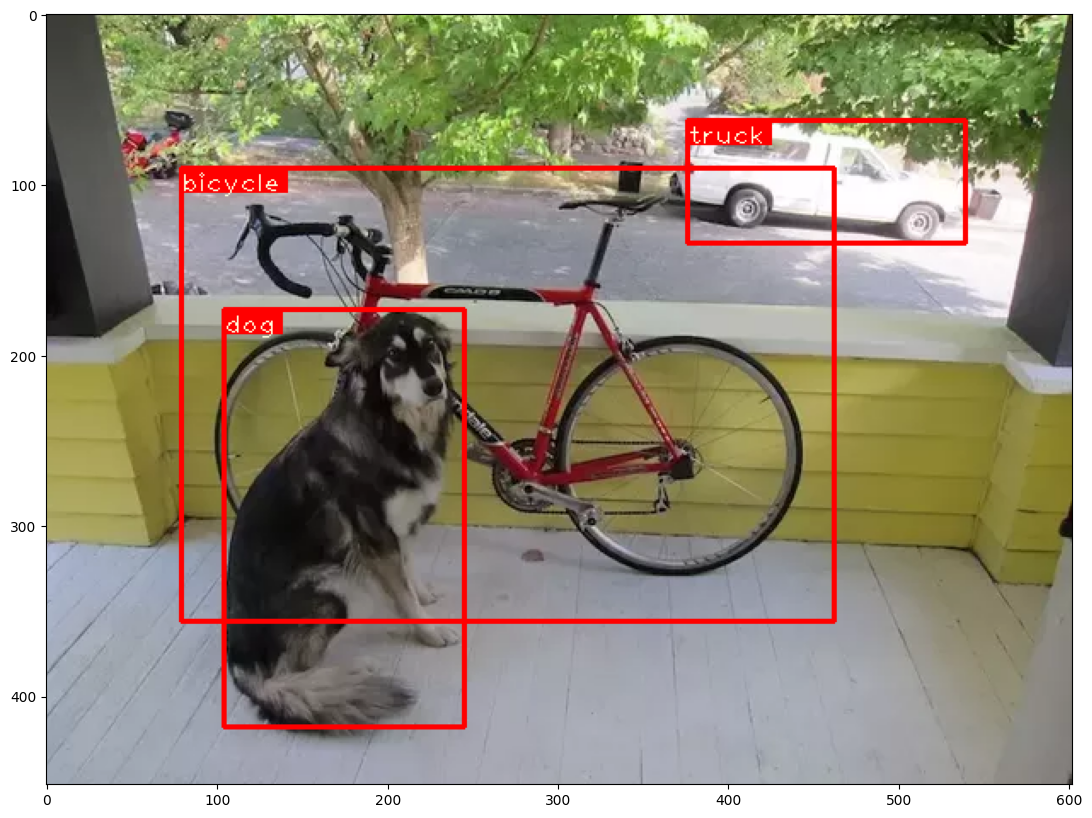

In [176]:
img = cv2.imread('working/output/det_dog-cycle-car.png') 
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img)

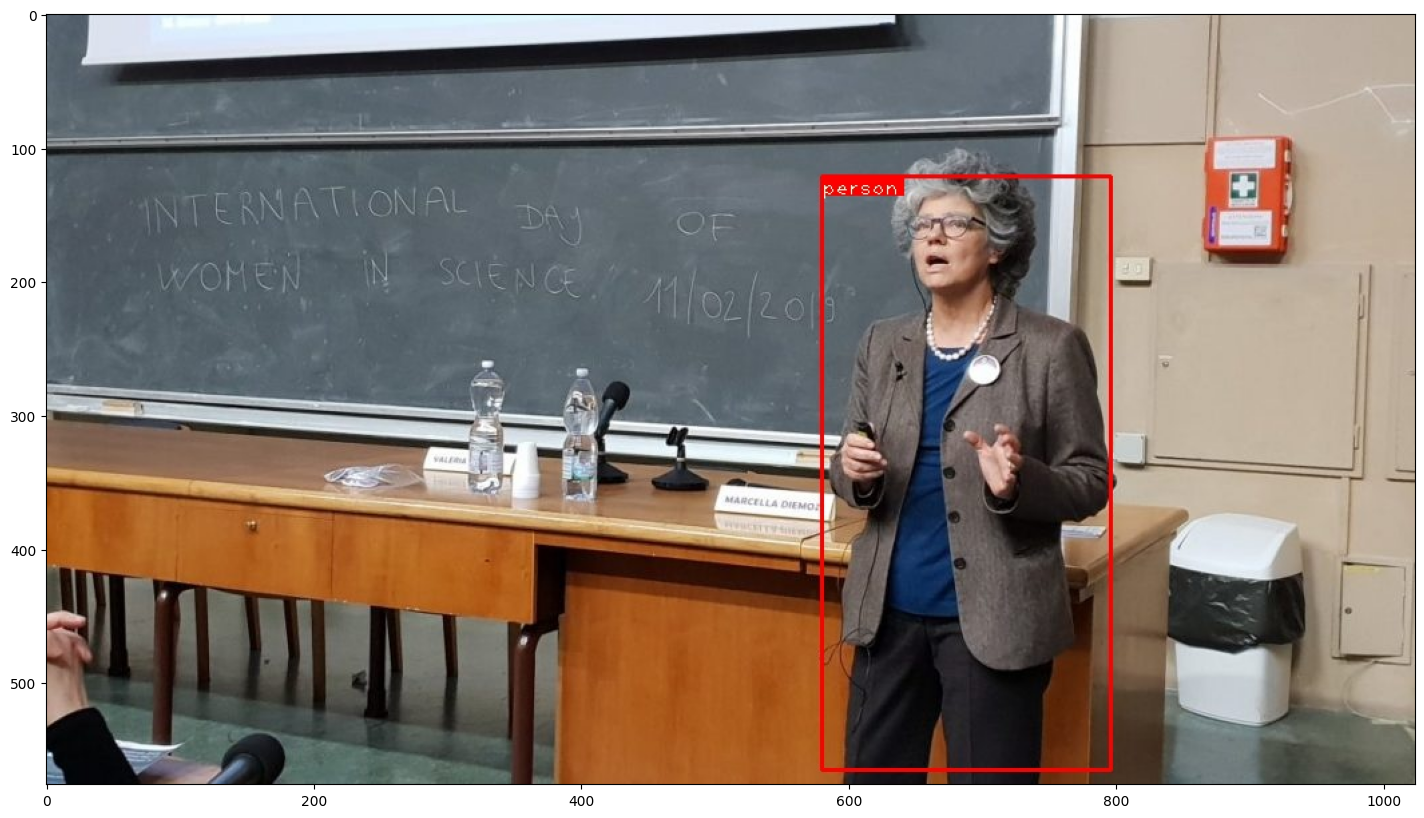

In [178]:
img = cv2.imread('working/output/det_marcella.jpg') 
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img)